In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import shap
import sys
import os
import matplotlib.pyplot as plt

# Scikit-learn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Config
try:
    project_root = os.path.dirname(os.getcwd())
    src_dir = os.path.join(project_root, "src")
    sys.path.append(src_dir)
    from modeling_pipeline_optimized import Config

    print("Successfully imported Config.")
except:
    print("Warning: Config import failed. Using manual paths.")

c:\Users\johnl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Successfully imported Config.


In [2]:
print("--- Preparing the Champion Model: LogisticRegression (Statistical Strategy) ---")

# 1. Load Data (Baseline CSV is the source for Statistical strategy)
# Note: Use the path appropriate for your system
dataset_path = os.path.join("..", "data", "processed", "baseline.csv")
df = pd.read_csv(dataset_path)

# 2. Encode Target
target_col = "Result"  # Adjust if needed based on Config
df[target_col] = df[target_col].map({"positive": 1, "negative": 0})
X = df.drop(columns=[target_col])
y = df[target_col]

# 3. Create the Peak Performance Split
# We use random_state=6 because that was the "Peak Recall" run in the experiments
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=6, stratify=y
)

# 4. Dynamic Feature Identification
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

# 5. Create the STATISTICAL Preprocessor
# This matches the strategy that hit 99.4% Recall
preprocessor = ColumnTransformer(
    transformers=[
        # Use Yeo-Johnson instead of Standard Scaler
        ("num", PowerTransformer(method="yeo-johnson"), numerical_features),
        # Use drop='if_binary' to clean up Gender coefficients
        (
            "cat",
            OneHotEncoder(drop="if_binary", handle_unknown="ignore"),
            categorical_features,
        ),
    ],
    remainder="passthrough",
)

# 6. Initialize the Champion Model
# Using params from Run 6: C=0.01, solver='lbfgs', class_weight=None
champion_model = LogisticRegression(
    C=0.01, class_weight=None, solver="lbfgs", random_state=6, max_iter=1000
)

# 7. Build and Train Pipeline
champion_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", champion_model),
    ]
)

champion_pipeline.fit(X_train, y_train)
print("\nChampion Statistical Model trained successfully.")

--- Preparing the Champion Model: LogisticRegression (Statistical Strategy) ---

Champion Statistical Model trained successfully.


In [3]:
print("--- Generating SHAP values ---")

# Extract steps
model = champion_pipeline.named_steps["classifier"]
preprocessor_fitted = champion_pipeline.named_steps["preprocessor"]

# Transform data for SHAP (Explainers need the numbers, not raw text)
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)

# Get Clean Feature Names
try:
    ohe_feature_names = (
        preprocessor_fitted.named_transformers_["cat"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
except AttributeError:
    ohe_feature_names = [f"Cat_{i}" for i in range(len(categorical_features))]

feature_names = numerical_features + ohe_feature_names

print("Feature Names extracted:", feature_names)

# Initialize LinearExplainer (Best for LR)
# We use the Training set as the background distribution
explainer = shap.LinearExplainer(
    model, X_train_transformed, feature_perturbation="interventional"
)

# Calculate SHAP values for the Test set
shap_values = explainer(X_test_transformed)

print("SHAP values calculated.")

--- Generating SHAP values ---
Feature Names extracted: ['Age', 'Hemoglobingdl', 'Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils', 'RBC', 'HCT', 'MCVfl', 'MCHpg', 'MCHCgdl', 'RDWCV', 'TotalPlateletCountcumm', 'MPVfl', 'PDW', 'PCT', 'TotalWBCcountcumm', 'Gender_Male']
SHAP values calculated.



SHAP Summary Plot (Global Feature Importance):


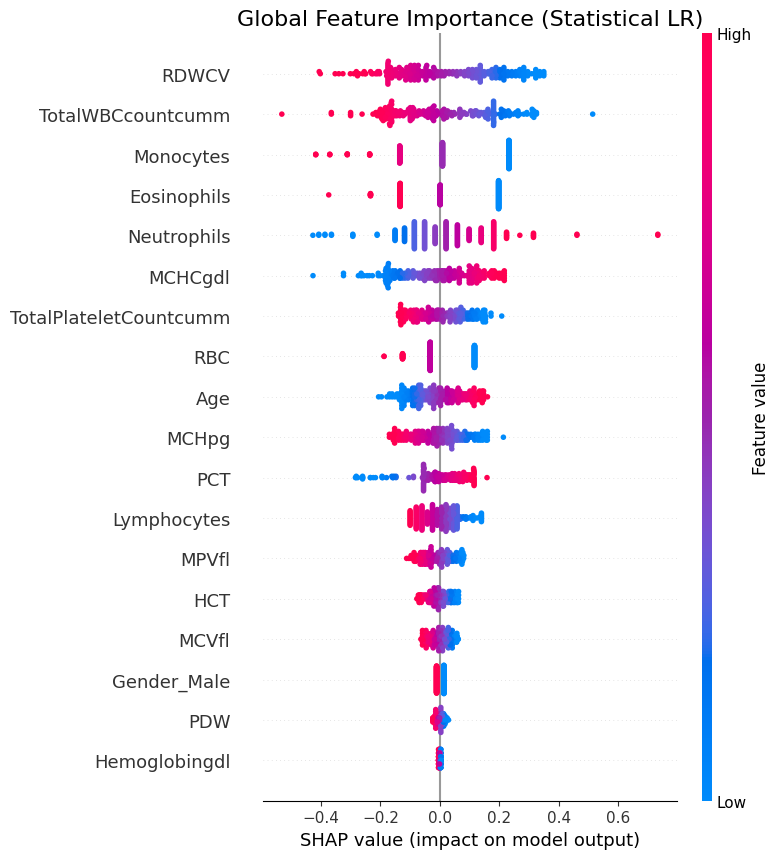

In [4]:
# --- GLOBAL INTERPRETABILITY ---
print("\nSHAP Summary Plot (Global Feature Importance):")

plt.figure()
shap.summary_plot(
    shap_values, X_test_transformed, feature_names=feature_names, show=False
)
plt.title("Global Feature Importance (Statistical LR)", fontsize=16)
plt.tight_layout()
plt.show()


Generating SHAP Waterfall Plot for a specific instance...
Analyzing Test Patient Index: 0


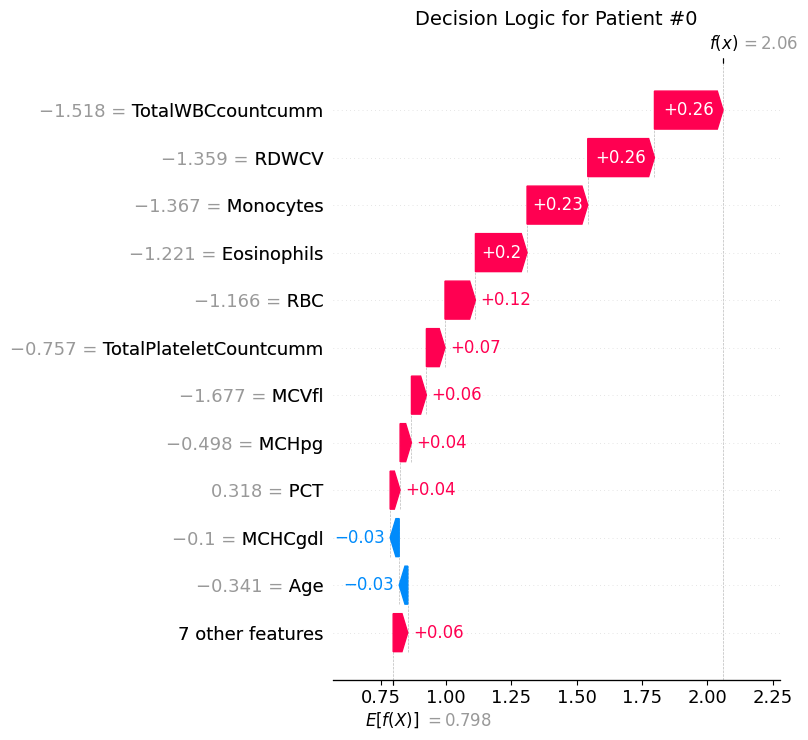

-> Insight: Red bars push risk UP (Pro-Dengue). Blue bars push risk DOWN (Anti-Dengue).


In [5]:
# --- LOCAL INTERPRETABILITY (Waterfall) ---
print("\nGenerating SHAP Waterfall Plot for a specific instance...")

# We need a proper Explanation object with feature names attached
# This fixes the display issue where features show as "Feature 0, Feature 1"
shap_explanation = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=X_test_transformed,
    feature_names=feature_names,
)

# Pick an interesting instance (e.g., a Positive Case)
# Let's find an index where the ground truth was Positive (1)
positive_indices = np.where(y_test.values == 1)[0]
target_idx = positive_indices[0]  # Pick the first positive patient

print(f"Analyzing Test Patient Index: {target_idx}")

plt.figure(figsize=(10, 8))
shap.waterfall_plot(shap_explanation[target_idx], max_display=12, show=False)
plt.title(f"Decision Logic for Patient #{target_idx}", fontsize=14)
plt.tight_layout()
plt.show()

print(
    "-> Insight: Red bars push risk UP (Pro-Dengue). Blue bars push risk DOWN (Anti-Dengue)."
)